# Imports

In [8]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

from scipy import stats
import scipy
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Load in the Dataset

In [2]:
tmdb = pd.read_csv('Data/2015-2019_tmdb_data.csv.gz')
tmdb.info()
tmdb.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21628 entries, 0 to 21627
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_id                21628 non-null  object 
 1   adult                  21628 non-null  float64
 2   backdrop_path          15757 non-null  object 
 3   belongs_to_collection  1324 non-null   object 
 4   budget                 21628 non-null  float64
 5   genres                 21628 non-null  object 
 6   homepage               5852 non-null   object 
 7   id                     21628 non-null  float64
 8   original_language      21628 non-null  object 
 9   original_title         21628 non-null  object 
 10  overview               21164 non-null  object 
 11  popularity             21628 non-null  float64
 12  poster_path            20849 non-null  object 
 13  production_companies   21628 non-null  object 
 14  production_countries   21628 non-null  object 
 15  re

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,tt0369610,0.0,/aIGIYJTyOkEVUmEd3z5x6diYsFx.jpg,"{'id': 328, 'name': 'Jurassic Park Collection'...",150000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.jurassicworld.com/,135397.0,en,Jurassic World,...,1.671537e+09,124.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The park is open.,Jurassic World,0.0,6.679,18891.0,PG-13
1,tt0420293,0.0,/b0p0OPx1ZDZVc8iDB1kle0Cc2H9.jpg,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}]",http://www.stanfordprisonexperimentfilm.com/,308032.0,en,The Stanford Prison Experiment,...,6.435570e+05,122.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,They were given 2 weeks. It lasted 6 days.,The Stanford Prison Experiment,0.0,6.900,835.0,R
2,tt0462335,0.0,/wESuRMxELPAwo56qFRcoyI4p20F.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",http://www.highrisefilm.com,254302.0,en,High-Rise,...,3.464720e+05,119.0,"[{'english_name': 'French', 'iso_639_1': 'fr',...",Released,Leave the real world behind,High-Rise,0.0,5.700,1025.0,R
3,tt0478970,0.0,/a7sAqMKv5tkAdMzFfIhPqIBmQ9g.jpg,"{'id': 422834, 'name': 'Ant-Man Collection', '...",130000000.0,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",http://marvel.com/movies/movie/180/ant-man,102899.0,en,Ant-Man,...,5.193120e+08,117.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Heroes don't get any bigger.,Ant-Man,0.0,7.083,18094.0,PG-13
4,tt0787524,0.0,/cJ6dqrHhts085zJTMaXECjp0RfX.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",http://www.ifcfilms.com/films/the-man-who-knew...,353326.0,en,The Man Who Knew Infinity,...,1.147245e+07,108.0,"[{'english_name': 'Sanskrit', 'iso_639_1': 'sa...",Released,What does it take to prove the impossible?,The Man Who Knew Infinity,0.0,7.184,1246.0,PG-13


One of the columns that will largely be used will be the 'certification' column. I want to check the value counts for the column to get the total number of certifications.

In [4]:
tmdb['certification'].value_counts()

R          1446
NR         1221
PG-13       858
PG          403
G           132
NC-17        47
Unrated       4
Name: certification, dtype: int64

In [5]:
# Combine 'NR' and 'Unrated' columns
tmdb['certification'] = tmdb['certification'].replace({'Unrated': 'NR'})
tmdb['certification'].value_counts()

R        1446
NR       1225
PG-13     858
PG        403
G         132
NC-17      47
Name: certification, dtype: int64

# Does the MPAA rating of a movie (G/PG/PG-13/R) affect how much revenue the movie generates?

## State the Null and Alternative Hypothesis
- Null Hypothesis: There is no significant difference between MPAA ratings and amount of revenue generated of a movie.
- Alternative Hypothesis: There is a significant difference between the MPAA rating of a movie and the amount of revenue generated.


## Determining the Correct Test
- The data is numeric.
- There are 6 groups: MPAA ratings G, PG, PG-13, R, NR, NC-17
- Which test to perform? One-Way ANOVA


## Visualize and Separate Features for Hypothesis
- The target column is 'revenue'
- The column that determines the group is 'certification'

## Remove Columns with Null Certification Values

In [6]:
cert = tmdb.copy()
cert.dropna(subset=['certification'], inplace=True)
cert.isna().sum()

imdb_id                     0
adult                       0
backdrop_path             599
belongs_to_collection    3628
budget                      0
genres                      0
homepage                 2141
id                          0
original_language           0
original_title              0
overview                   11
popularity                  0
poster_path                62
production_companies        0
production_countries        0
release_date                0
revenue                     0
runtime                     0
spoken_languages            0
status                      0
tagline                  1409
title                       0
video                       0
vote_average                0
vote_count                  0
certification               0
dtype: int64

Now that the dataset has been filtered for movies that have certification, I can now compare the 4 groups for revenue amounts.

## Visualizing Groups and Revenue

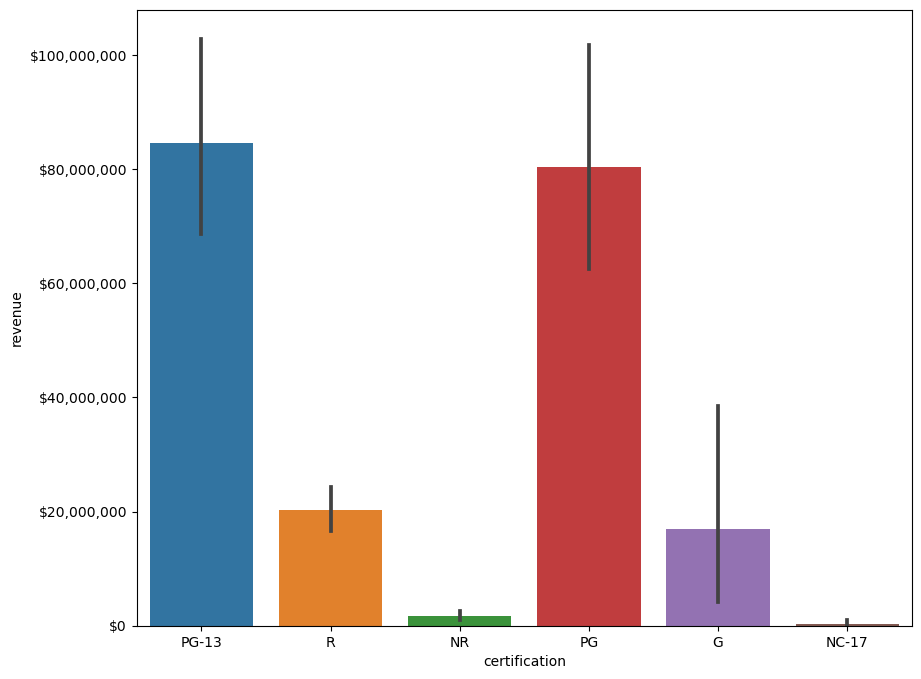

In [10]:
fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(data=cert, x='certification',y='revenue');

price_fmt = mpl.ticker.StrMethodFormatter('${x:,.0f}')
ax.yaxis.set_major_formatter(price_fmt)

## Separating the Groups

Each group will need to be separated in order to be analyzed

In [11]:
groups = {}
## Loop through all unique categories
for i in cert['certification'].unique():
    ## Get series for group and rename
    data = cert.loc[cert['certification']==i,'revenue'].copy()
    
    # save into the dictionary
    groups[i] = data
groups.keys()

dict_keys(['PG-13', 'R', 'NR', 'PG', 'G', 'NC-17'])

## Test for Normality

In [12]:
## Running normal test on each group and confirming there are >20 in each group
norm_results = {}
for i, data in groups.items():
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results[i] = {'n': len(data),
                             'p':p,
                             'test stat':stat,}
## convert to a dataframe
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df

,n,p,test stat
PG-13,858.0,1.297074e-197,906.698304
R,1446.0,0.000000e+00,1881.210106
NR,1225.0,0.000000e+00,2160.558226
PG,403.0,1.476717e-79,363.028801
G,132.0,3.814987e-55,250.606486
NC-17,47.0,5.301539e-23,102.582920


In [13]:
# checking sig with pandas 
norm_results_df['sig'] = norm_results_df['p'] < .05 
norm_results_df

,n,p,test stat,sig
PG-13,858.0,1.297074e-197,906.698304,True
R,1446.0,0.000000e+00,1881.210106,True
NR,1225.0,0.000000e+00,2160.558226,True
PG,403.0,1.476717e-79,363.028801,True
G,132.0,3.814987e-55,250.606486,True
NC-17,47.0,5.301539e-23,102.582920,True


Each group has over 20 samples, so the test for normality can be passed.

## Test for Equal Variance

In [14]:
stats.levene(*groups.values())

LeveneResult(statistic=47.39937363782326, pvalue=8.390754236016758e-48)

Because p < 0.05, the test did meet the assumption for equal variance. An alternate test will need to be used for final ANOVA hypothesis test.

## Final Hypothesis Test

In [16]:
# using alternate test, ''
result = stats.kruskal( *groups.values())
result

KruskalResult(statistic=580.8012479161063, pvalue=2.8425813727998375e-123)

The p-value is significantly less than alpha (0.05), but with 6 different groups, it's hard to know which ones, or all, are less than alpha. I now need to use Tukey's Pairwise Multiple Comparisons Test in order to find which ones are significantly less.

### Tukey's Pairwise Multiple Comparisons Test

In [17]:
# save the values as revenue and the labels to the certification
values = cert['revenue']
labels = cert['certification']

In [18]:
# perform tukey's multiple comparison test and display the summary
tukeys_results = pairwise_tukeyhsd(values,labels)
tukeys_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
G,NC-17,-16700303.3272,0.9822,-84890435.6619,51489829.0075,False
G,NR,-15275837.2685,0.8446,-52051950.3573,21500275.8203,False
G,PG,63373985.3984,0.0001,23114491.1653,103633479.6315,True
G,PG-13,67562578.9557,0.0,30029179.5665,105095978.3449,True
G,R,3302334.1328,0.9998,-33199383.3748,39804051.6405,False
NC-17,NR,1424466.0587,1.0,-58245734.105,61094666.2224,False
NC-17,PG,80074288.7256,0.0031,18196367.2224,141952210.2289,True
NC-17,PG-13,84262882.2829,0.0009,24122992.3315,144402772.2343,True
NC-17,R,20002637.4601,0.9309,-39498838.7793,79504113.6994,False
NR,PG,78649822.6669,0.0,55596286.8067,101703358.5271,True


From the summary above, there are more certifications that are significantly different than those that are not.

- G is significantly different than PG and PG-13
- PG is significantly different than G, NC-17, NR, and R
- PG-13 is significantly different than G, PG, R, NR, and NC-17
- R is significantly different than PG, PG-13, and NR
- NR is significantly different than PG, PG-13, and R
- NC-17 is significantly different than PG and PG-13